In [1]:
%matplotlib ipympl
import pyLinViscoFit as visco
from pyLinViscoFit import styles
styles.format_fig()

***
# Verification - Comparison with APDL 2021 R1

## Raw measurement data in frequency domain

In [2]:
#Load Eplexor raw measurement data
epl_raw = visco.load.file('./examples/freq_Eplexor_raw.xls')
df_raw, arr_RefT = visco.load.Eplexor_raw(epl_raw)

#Load user provided aT
RefT = -5
#shift = visco.load.file('./verification/freq_raw/freq_Eplexor_raw_aT.csv')
#df_aT = visco.load.user_shift(shift)

#Time
# epl_raw = visco.load.file('./examples/time_user_raw.csv')
# df_raw, arr_RefT = visco.load.user_raw(epl_raw, 'time')
# RefT = -5
# shift = visco.load.file('./examples/time_user_raw__shift_factors.csv')
# df_aT = visco.load.user_shift(shift)

#Or use shift algorithmn from this notebook (uncomment following line)
df_aT = visco.master.get_aT(df_raw, RefT)

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [4]:
#Create df_aT
Temp = []
for i, df_set in df_raw.groupby('Set'):
    T = df_set['T_round'].iloc[0]
    Temp.append(T)
    if T == RefT:
        idx = i
df_aT = pd.DataFrame(Temp, columns=['Temp'])
df_aT['log_aT'] = np.nan 

fig, ax = plt.subplots()

#Set shift factor at RefT
df_aT.loc[idx]['log_aT'] = 0

#Shift below RefT
for i in range(idx, 0, -1):
    df_aT.loc[i-1]['log_aT'] = get_at_pwr(df_raw, i, i-1)[0] + df_aT.loc[i]['log_aT']
    
#Shift above RefT
for i in range(idx, df_aT.shape[0]-1, 1):
    df_aT.loc[i+1]['log_aT'] = get_at_pwr(df_raw, i, i+1)[0] + df_aT.loc[i]['log_aT']
    
fig.show()

NameError: name 'get_at_pwr' is not defined

In [5]:
def pwr_y(x, a, b, e):
    return a*x**b+e

def pwr_x(y, a, b, e):
    return ((y-e)/a)**(1/b)

In [11]:
df = df_raw

gb_ref = 0
gb_shift = 1

if df_raw.domain == 'freq':
    _modul = 'E_stor'
elif df_raw.domain == 'time':
    _modul = 'E_relax'

gb = df_raw.groupby('Set')

ref_xdata   = gb.get_group(gb_ref)['f_set'].values
ref_ydata   = gb.get_group(gb_ref)[_modul].values
shift_xdata = gb.get_group(gb_shift)['f_set'].values
shift_ydata = gb.get_group(gb_shift)[_modul].values

#Curve fit power law
ref_popt, ref_pcov = curve_fit(pwr_y, ref_xdata, ref_ydata, maxfev=10000)
shift_popt, shift_pcov = curve_fit(pwr_y, shift_xdata, shift_ydata, maxfev=10000)

#Check and remove first measurement point if outlier
ref_popt_rem, ref_pcov_rem = curve_fit(pwr_y, ref_xdata[1:], ref_ydata[1:], maxfev=10000)
perr = np.sqrt(np.abs(np.diag(ref_pcov)))
perr_rem = np.sqrt(np.abs(np.diag(ref_pcov_rem)))
if all(perr_rem < perr):
    ref_popt = ref_popt_rem
    ref_xdata = ref_xdata[1:] 
    ref_ydata = ref_ydata[1:]

shift_popt_rem, shift_pcov_rem = curve_fit(pwr_y, shift_xdata[1:], shift_ydata[1:], maxfev=10000)
perr = np.sqrt(np.abs(np.diag(shift_pcov)))
perr_rem = np.sqrt(np.abs(np.diag(shift_pcov_rem)))
if all(perr_rem < perr):
    shift_popt = shift_popt_rem
    shift_xdata = shift_xdata[1:] 
    shift_ydata = shift_ydata[1:]

#Calculate fit
ref_ydata_fit = pwr_y(ref_xdata, *ref_popt)
shift_ydata_fit = pwr_y(shift_xdata, *shift_popt)

#Get interpolation or extrapolation range
if ref_ydata_fit.max() > shift_ydata_fit.max():
    #Ref is on top
    top_xdata = ref_xdata
    top_ydata = ref_ydata
    top_popt = ref_popt
    bot_xdata = shift_xdata
    bot_ydata = shift_ydata
    bot_popt = shift_popt
    sign = 1
else:
    #Shift is on top
    top_xdata = shift_xdata
    top_ydata = shift_ydata   
    top_popt = shift_popt
    bot_xdata = ref_xdata
    bot_ydata = ref_ydata
    bot_popt = ref_popt
    sign = -1
    
if top_ydata.min() < bot_ydata.max():
    #overlap range
    ymin = top_ydata.min()
    ymax = bot_ydata.max()
else:
    #gap range
    ymin = bot_ydata.max()
    ymax = top_ydata.min()   
    
#Define three points along inter/extrapolation range
ymid = (ymin+ymax)/2
y = np.array([ymin, ymid, ymax])

#Compute average shift factor for the three points
x_top = pwr_x(y, *top_popt)
x_bot = pwr_x(y, *bot_popt)

log_aT = sign * np.log10(x_top/x_bot).mean()

#return log_aT, refpopt, shiftpopt

In [10]:
gb.get_group(gb_ref)['f_set'].values

array([  0.1     ,   0.215443,   0.464159,   1.      ,   2.15443 ,
         4.64159 ,  10.      ,  21.5443  ,  46.4159  , 100.      ])

In [13]:
shift_ydata

array([8438.97609164, 8584.64838172, 8611.50957696, 8631.46113526,
       8685.49359646, 8759.57566963, 8784.2597029 , 8841.74322326,
       8900.48198436, 8974.48013473])

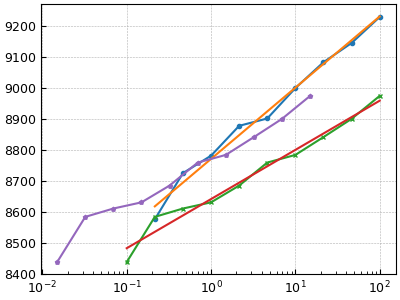

In [15]:
import matplotlib.pyplot as plt


plt.semilogx(ref_xdata, ref_ydata, marker='o')
plt.semilogx(ref_xdata, ref_ydata_fit)
plt.semilogx(shift_xdata, shift_ydata, marker='x')
plt.semilogx(shift_xdata, shift_ydata_fit)


fshift = 10**log_aT.mean() * shift_xdata
plt.semilogx(fshift, shift_ydata, marker='p')
#plt.semilogx(fshift, shift_ydata_fit)
plt.show()

In [25]:
np.append(shiftx, fshift)

array([1.00000000e-01, 2.15443000e-01, 4.64159000e-01, 1.00000000e+00,
       2.15443000e+00, 4.64159000e+00, 1.00000000e+01, 2.15443000e+01,
       4.64159000e+01, 1.00000000e+02, 1.76678271e+08, 3.80640967e+08,
       8.20068095e+08, 1.76678271e+09, 3.80640967e+09, 8.20068095e+09,
       1.76678271e+10, 3.80640967e+10, 8.20068095e+10, 1.76678271e+11])

In [5]:
def poly1(x,C0,C1):
    return C0+C1*x

def poly2(x,C0,C1,C2):
    return C0+C1*x+C2*x**2

def poly3(x,C0,C1,C2,C3):
    return C0+C1*x+C2*x**2+C3*x**3

def poly4(x,C0,C1,C2,C3,C4):
    return C0+C1*x+C2*x**2+C3*x**3+C4*x**4

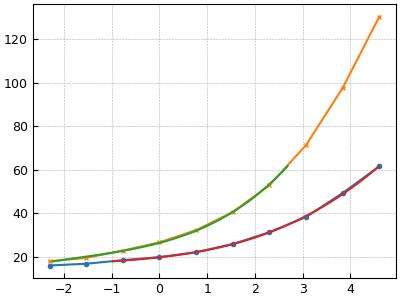

In [263]:
df = df_raw

gb_ref = 20
gb_shift = 19

if df.domain == 'freq':
    _modul = 'E_stor'
elif df.domain == 'time':
    _modul = 'E_relax'

gb = df.groupby('Set')

points = 100

ref_xdata = np.log(gb.get_group(gb_ref)['f_set'])
ref_ydata = gb.get_group(gb_ref)[_modul]
ref_poly = np.polyfit(ref_xdata, ref_ydata, 4)
p_ref = np.poly1d(ref_poly)


shift_xdata = np.log(gb.get_group(gb_shift)['f_set'])
shift_ydata = gb.get_group(gb_shift)[_modul]
shift_poly = np.polyfit(shift_xdata, shift_ydata, 4)
p_shift = np.poly1d(shift_poly)


# ref_popt, _pcov = curve_fit(poly4, ref_xdata, ref_ydata)
# ref_xdata_fit = np.linspace(ref_xdata.min(), ref_xdata.max(), points)
# ref_ydata_fit = poly4(ref_xdata_fit, *ref_popt)
# shift_popt, _pcov = curve_fit(poly4, shift_xdata, shift_ydata)
# shift_xdata_fit = np.linspace(ref_xdata.min(), ref_xdata.max(), points)
# shift_ydata_fit = poly4(shift_xdata_fit, *shift_popt)

if ref_ydata_fit.max() > shift_ydata_fit.max():
    #Ref is on top
    top_xdata = ref_xdata
    top_ydata = ref_ydata
    p_top = p_ref
    p_top_coeff = ref_poly
    
    bot_xdata = shift_xdata
    bot_ydata = shift_ydata
    p_bot = p_shift
    p_bot_coeff = shift_poly
else:
    #Shift is on top
    top_xdata = shift_xdata
    top_ydata = shift_ydata
    p_top = p_shift
    p_top_coeff = shift_poly
    
    bot_xdata = ref_xdata
    bot_ydata = ref_ydata
    p_bot = p_ref
    p_bot_coeff = ref_poly
    
if top_ydata.min() < bot_ydata.max():
    #overlap range
    ymin = top_ydata.min()
    ymax = bot_ydata.max()
      
else:
    #gap range
    ymin = bot_ydata.max()
    ymax = top_ydata.min()    
    
    
top_xmin = (p_top - ymin).roots 
top_xmax = (p_top - ymax).roots 
#top_xmin = top_xmin[np.isreal(top_xmin)].real
#top_xmax = top_xmax[np.isreal(top_xmax)].real
top_xmin = top_xmin.real
top_xmax = top_xmax.real
    
bot_xmin = (p_bot - ymin).roots 
bot_xmax = (p_bot - ymax).roots 
#bot_xmin = bot_xmin[np.isreal(bot_xmin)].real
#bot_xmax = bot_xmax[np.isreal(bot_xmax)].real
bot_xmin = bot_xmin.real
bot_xmax = bot_xmax.real

top_xmax = top_xmax[top_xmax>=top_xmin]
bot_xmax = bot_xmax[bot_xmax>=bot_xmin]
    
top_xmin = top_xmin[np.abs(x0min-top_xmin).argmin()]
top_xmax = top_xmax[np.abs(x0min-top_xmax).argmin()]
bot_xmin = bot_xmin[np.abs(x0max-bot_xmin).argmin()]
bot_xmax = bot_xmax[np.abs(x0max-bot_xmax).argmin()]
    
top_xrange = np.linspace(top_xmin, top_xmax)
bot_xrange = np.linspace(bot_xmin, bot_xmax)
    
top_yrange = p_top(top_xrange)
bot_yrange = p_bot(bot_xrange)




    
plt.plot(ref_xdata, ref_ydata, marker='o')
#plt.plot(ref_xdata, ref_ydata_fit)

plt.plot(shift_xdata, shift_ydata, marker='x')
#plt.plot(shift_xdata_fit, shift_ydata_fit)

plt.plot(top_xrange, top_yrange)
plt.plot(bot_xrange, bot_yrange)

aT = -3.73914373
#plt.plot(aT + bot_xrange, bot_yrange)


shifted_xdata = aT + shift_xdata
#plt.plot(shifted_xdata_fit, shift_ydata, marker='x')
plt.show()


if aT<0:
    log_aT = -np.log((np.abs(aT)))
elif aT > 0:
    log_aT = np.log(aT)
else:
    log_aT = 0



In [247]:
bot_yrange

75    3485.365426
76    3529.136390
77    3575.057222
78    3621.017045
79    3655.249912
Name: E_stor, dtype: float64

In [236]:
top_xmax

array([-2.36566867])

In [249]:
from scipy.optimize import minimize, nnls
def shift(aT, top_xrange, bot_xrange):
    return np.sum((top_xrange - (aT + bot_xrange))**2)

aT = 0
res = minimize(shift, aT, args=(top_xrange, bot_xrange))

In [257]:
top_xrange - bot_xrange

60   NaN
61   NaN
62   NaN
63   NaN
75   NaN
76   NaN
77   NaN
78   NaN
79   NaN
Name: f_set, dtype: float64

In [253]:
shift(aT, top_xrange, bot_xrange)

0.0

In [252]:
bot_xrange

75    1.535057
76    2.302585
77    3.070111
78    3.837642
79    4.605170
Name: f_set, dtype: float64

In [40]:
ref_poly = np.polyfit(ref_xdata, ref_ydata, 4)
p_ref = np.poly1d(ref_poly)
(p_ref).roots

array([ 7.73941142+6.1493246j ,  7.73941142-6.1493246j ,
       -5.32861014+5.50568349j, -5.32861014-5.50568349j])

In [38]:
(p_ref - ymin).roots

array([-4.6457293 +0.j        ,  4.09173509+2.86216972j,
        4.09173509-2.86216972j,  1.28386168+0.j        ])

In [35]:
ymin

3723.603930466392

In [27]:
xrefint

3479.1668123492873

In [28]:
xshiftint

4125.59181208038

In [23]:
plt.show()

In [6]:
#Linear function shift
def log_func(x, k, d):
    return k*np.log(x)+d




def get_at(df, gb_ref, gb_shift):

    gb = df.groupby('Set')

    refx = gb.get_group(gb_ref)["f_set"]
    refy = gb.get_group(gb_ref)["E_stor"]

    refpopt, ref_pcov = curve_fit(log_func, refx, refy)

    shiftx = gb.get_group(gb_shift)["f_set"]
    shifty = gb.get_group(gb_shift)["E_stor"]

    shiftpopt, shift_pcov = curve_fit(log_func, shiftx, shifty)

    k1 = refpopt[0]
    d1 = refpopt[1]
    k2 = shiftpopt[0]
    d2 = shiftpopt[1]

    xrefint = log_func(gb.get_group(gb_ref)["f_set"], *refpopt).min()
    xshiftint = log_func(gb.get_group(gb_shift)["f_set"], *shiftpopt).max()

    yint = (xrefint+xshiftint)/2
    refxi = np.exp((yint-d1)/k1)
    shiftxi = np.exp((yint-d2)/k2)
    log_aT = np.log10(refxi/shiftxi)

    return log_aT, refpopt, shiftpopt



def get_at_pwr(df, gb_ref, gb_shift):

    if df.domain == 'freq':
        _modul = 'E_stor'
    elif df.domain == 'time':
        _modul = 'E_relax'

    gb = df.groupby('Set')

    refx = gb.get_group(gb_ref)['f_set']
    refy = gb.get_group(gb_ref)[_modul]

    refpopt, ref_pcov = curve_fit(log_func_pwr, refx, refy)

    shiftx = gb.get_group(gb_shift)['f_set']
    shifty = gb.get_group(gb_shift)[_modul]

    shiftpopt, shift_pcov = curve_fit(log_func_pwr, shiftx, shifty)

    a1 = refpopt[0]
    b1 = refpopt[1]
    a2 = shiftpopt[0]
    b2 = shiftpopt[1]

    xrefint = log_func_pwr(gb.get_group(gb_ref)['f_set'], *refpopt).min()
    xshiftint = log_func_pwr(gb.get_group(gb_shift)['f_set'], *shiftpopt).max()

    yint = (xrefint+xshiftint)/2
    refxi = (yint/a1)**(1/b1)
    shiftxi = (yint/a2)**(1/b2)
    log_aT = np.log10(refxi/shiftxi)
    
    ax.semilogx(refx, refy)
    ax.semilogx(refx, log_func_pwr(refx, *refpopt))

    ax.semilogx(shiftx, shifty)
    ax.semilogx(shiftx, log_func_pwr(shiftx, *shiftpopt))
    
    return log_aT, refpopt, shiftpopt

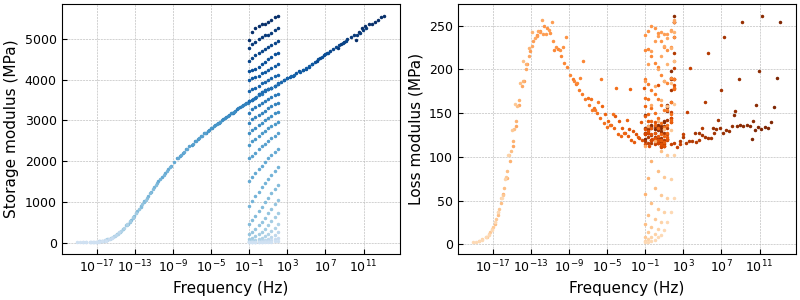

In [5]:
#Create master curve
df_master = visco.master.get_curve(df_raw, df_aT, RefT)
fig_master_shift = visco.master.plot_shift(df_raw, df_master)

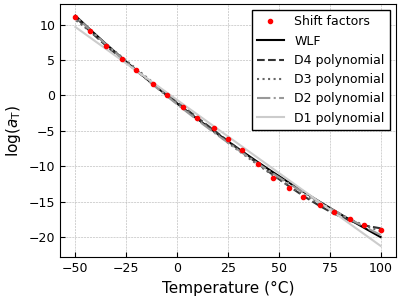

In [4]:
#Shift functions
df_WLF = visco.shift.fit_WLF(df_master.RefT, df_aT)
df_poly = visco.shift.fit_poly(df_aT)

fig_shift, df_shift = visco.shift.plot(df_aT, df_WLF, df_poly)

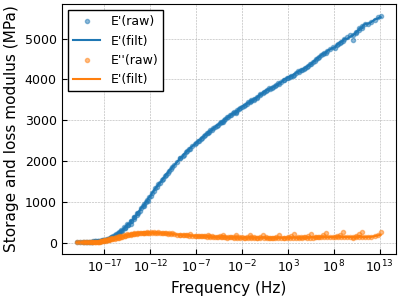

In [5]:
#Smooth master curve
win = 5
df_master = visco.master.smooth(df_master, win)
fig_smooth = visco.master.plot_smooth(df_master)

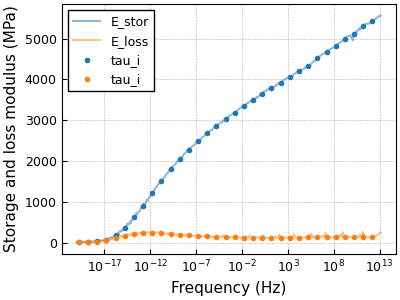

In [6]:
#Discretize number of Prony terms
df_dis = visco.prony.discretize(df_master)
fig_dis = visco.prony.plot_dis(df_master, df_dis)

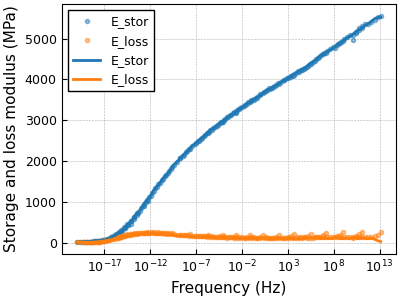

In [7]:
#Fit Prony series parameter
prony, df_GMaxw = visco.prony.fit(df_dis)
fig_fit = visco.prony.plot_fit(df_master, df_GMaxw)

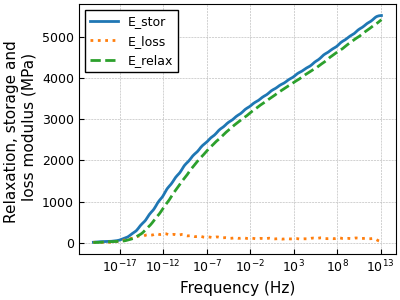

In [8]:
#Plot Generalized Maxwell model
fig_GMaxw = visco.prony.plot_GMaxw(df_GMaxw);

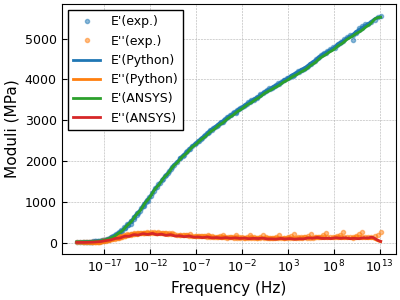

In [9]:
#Compare Python fit with ANSYS APDL
df_prony_ANSYS = visco.verify.load_prony_ANSYS('./freq_raw/prony_terms.MPL')
prony_ANSYS = visco.verify.prep_prony_ANSYS(df_prony_ANSYS, prony)
nprony = prony_ANSYS['df_terms'].shape[0]
df_GMaxw_ANSYS = visco.prony.calc_GMaxw(**prony_ANSYS, decades = nprony)
fig_fit_ANSYS = visco.verify.plot_fit_ANSYS(df_master, df_GMaxw, df_GMaxw_ANSYS)

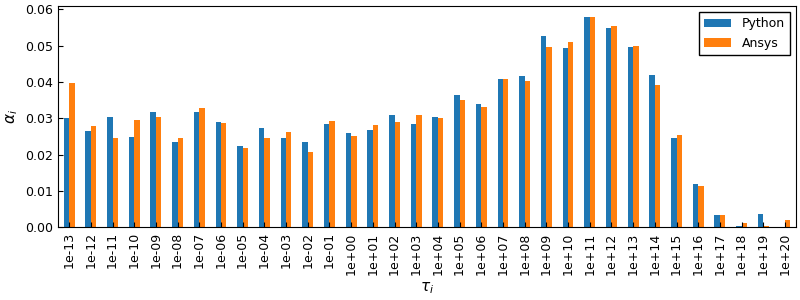

In [10]:
fig_coeff = visco.prony.plot_param([prony, prony_ANSYS], ['Python', 'Ansys'])